In [1]:
# Standard libraries
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Going to make sure we can load all the custom scripts from the directory
scripts_dir = r"C:\Users\Mark.DESKTOP-UFHIN6T\Projects\sovereign-risk-THA\scripts\analysis"
# Add scripts directory to sys.path
if scripts_dir not in sys.path:
    sys.path.append(scripts_dir)

In [11]:
from model_dependence import model_dependence
from analysis_functions import basin_loss_curve, interpolate_damages, get_copula_model, generate_conditional_sample

In [4]:
# Calculate dependency using copulas
clayton_copula_models, ordered_basins = model_dependence()

In [7]:
# Load risk data
risk_data_file = r"D:\projects\sovereign-risk\Thailand\analysis\flood\risk_analysis\dignad\exposure\risk_basin_zonal_sum.csv"
risk_data = pd.read_csv(risk_data_file)
# Add columne for annual exceedance probability
risk_data['AEP'] = 1 / risk_data['RP']
# Add a column converting current prorection level into AEP
risk_data['Pr_L_AEP'] = np.where(risk_data['Pr_L'] == 0, 0, 1 / risk_data['Pr_L']) # using numpy where avoids zero division errors
# Add row for each combination that sums residential and non-residential damages
grouped = risk_data.groupby(['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'], as_index=False)['damages'].sum()
grouped['urban_class'] = 'Combined'  # Add a column for urban_class with value 'total'
risk_data = pd.concat([risk_data, grouped], ignore_index=True).sort_values(by=['FID', 'GID_1', 'NAME', 'HB_L4', 'HB_L5', 'HB_L6', 'HB_L7', 'Pr_L', 'Pr_L_AEP', 'Add_Pr', 'New_Pr_L', 'epoch', 'adaptation_scenario', 'RP', 'AEP'])
risk_data.reset_index(drop=True, inplace=True)

In [12]:
# Function for sectoral monte carlo simulation
def sectoral_monte_carlo_dependence_simulation(loss_df, rps, basin_col, epoch_val, scenario_val, protection_level, num_years, ordered_basins, copula_models, num_simulations=10000):
    '''
    Perform Monte Carlo simulations of yearly losses incorporating basin dependencies.
    Same as the monte carlo dependence simulation, except it now outputs sectoral losses.

    :param loss_df: dataframe with losses from risk analysis
    :param rps: list of return periods to consider. 
    :param basin_col: name of column for basins (e.g. 'HB_L6')
    :param epoch_val: name of epoch value (e.g. 'Today')
    :param scenario_val: name of scenario (e.g. 'Baseline')
    :param protection_level: what is the baseline protection level (e.g. 0.5 or 1 in 2 years)
    :param num_years: Number of years to simulate
    :param ordered_basins: List of basin IDs ordered by dependency
    :param copula_models: Dictionary holding copula model for each basin pair
    :param num_simulations: Number of simulations (default is 10,000).
    :return: Dataframe of simulated national losses for each year, for each sector
    '''

    # To speed up the Monte-Carlo simulation we are going to pre-compute some variables
    # precompute loss-probability curves for each basin for the four ectors
    
    res_basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, "Residential", rps) for basin_id in ordered_basins}
    com_basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, "Commercial", rps) for basin_id in ordered_basins}
    ind_basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, "Industrial", rps) for basin_id in ordered_basins}
    inf_basin_loss_curves = {basin_id: basin_loss_curve(loss_df, basin_id, basin_col, epoch_val, scenario_val, "Infrastructure", rps) for basin_id in ordered_basins}
    
    # Initialize arrays for national losses
    res_national_losses_per_year = np.zeros((num_simulations, num_years))
    com_national_losses_per_year = np.zeros((num_simulations, num_years))
    ind_national_losses_per_year = np.zeros((num_simulations, num_years))
    inf_national_losses_per_year = np.zeros((num_simulations, num_years))
    # Generate all random numbers in advance
    random_numbers = np.random.uniform(0, 1, (num_simulations, num_years, len(ordered_basins))).astype(np.float32)

    for simulation in range(num_simulations):
        # # print progress
        # if simulation % 50 == 0:
        #     print('Simulation progress: %s out of %s' % (simulation, num_simulations))
        for year in range(num_years):
            # Initialize a list to store losses for each basin for the current year
            yearly_losses = []
            res_yearly_loss_values = []
            com_yearly_loss_values = []
            ind_yearly_loss_values = []
            inf_yearly_loss_values = []
            for i, basin_id in enumerate(ordered_basins):
                # print(basin_id)
                if i == 0:
                    # Handle first basin
                    r = random_numbers[simulation, year, i]
                    res_loss_curves = res_basin_loss_curves[basin_id]
                    com_loss_curves = com_basin_loss_curves[basin_id]
                    ind_loss_curves = ind_basin_loss_curves[basin_id]
                    inf_loss_curves = inf_basin_loss_curves[basin_id]
                    basin_loss = 0
                    yearly_losses.append(r) # add current loss simulation to the list
                    for Pr_L in res_loss_curves: # loop through basin protection levels
                        if Pr_L <= r:
                            # print(Pr_L, 'smaller than', r, 'continuing...') # if baseline protection is achieved...
                            continue
                        else:
                            res_yearly_loss_values.append(interpolate_damages(rps, res_loss_curves[Pr_L], r, protection_level))
                            com_yearly_loss_values.append(interpolate_damages(rps, com_loss_curves[Pr_L], r, protection_level))
                            ind_yearly_loss_values.append(interpolate_damages(rps, ind_loss_curves[Pr_L], r, protection_level))
                            inf_yearly_loss_values.append(interpolate_damages(rps, inf_loss_curves[Pr_L], r, protection_level))
                            
                else:
                    res_loss_curves = res_basin_loss_curves[basin_id]
                    com_loss_curves = com_basin_loss_curves[basin_id]
                    ind_loss_curves = ind_basin_loss_curves[basin_id]
                    inf_loss_curves = inf_basin_loss_curves[basin_id]
                    # Handle subsequent basins with dependencies
                    copula = get_copula_model(copula_models, ordered_basins[i-1], basin_id)
                    if copula is not None:
                        # Apply dependency model if theta exists
                        r = random_numbers[simulation, year, i]
                        previous_loss = yearly_losses[i-1]
                        current_loss = generate_conditional_sample(previous_loss, copula.theta, r)
                        yearly_losses.append(current_loss)
                        # TODO: need to check below assumption. Currently, the (1-current_loss) criteria leads to stupid results.
                        # in the below interpolation the (1-current_loss) part of the equation is critical.
                        # because the copula is optimized to model tail dependencies (e.g. > 0.9) and our AEPs are 
                        # essentially inverted (e.g. 0.001 is extreme) we need to invert the random number for interpolating the
                        # losses. This changes nothing apart from ensuring tail dependency is preserved. 
                        for Pr_L in res_loss_curves: # loop through basin protection levels
                            if Pr_L <= current_loss:
                                # print(Pr_L, 'smaller than', r, 'continuing...') # if baseline protection is achieved...
                                continue
                            else:
                                res_yearly_loss_values.append(interpolate_damages(rps, res_loss_curves[Pr_L], current_loss, protection_level))
                                com_yearly_loss_values.append(interpolate_damages(rps, com_loss_curves[Pr_L], current_loss, protection_level))
                                ind_yearly_loss_values.append(interpolate_damages(rps, ind_loss_curves[Pr_L], current_loss, protection_level))
                                inf_yearly_loss_values.append(interpolate_damages(rps, inf_loss_curves[Pr_L], current_loss, protection_level))
                    else:
                        # Independent simulation for this basin
                        r = random_numbers[simulation, year, i]
                        yearly_losses.append(r)
                        for Pr_L in res_loss_curves: # loop through basin protection levels
                            if Pr_L <= r:
                                continue
                            else:
                                res_yearly_loss_values.append(interpolate_damages(rps, res_loss_curves[Pr_L], r, protection_level))
                                com_yearly_loss_values.append(interpolate_damages(rps, com_loss_curves[Pr_L], r, protection_level))
                                ind_yearly_loss_values.append(interpolate_damages(rps, ind_loss_curves[Pr_L], r, protection_level))
                                inf_yearly_loss_values.append(interpolate_damages(rps, inf_loss_curves[Pr_L], r, protection_level))

            # Aggregate losses for the current year
            res_national_losses_per_year[simulation, year] = sum(res_yearly_loss_values)
            com_national_losses_per_year[simulation, year] = sum(com_yearly_loss_values)
            ind_national_losses_per_year[simulation, year] = sum(ind_yearly_loss_values)
            inf_national_losses_per_year[simulation, year] = sum(inf_yearly_loss_values)

    res_df = pd.DataFrame(res_national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])
    com_df = pd.DataFrame(com_national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])
    ind_df = pd.DataFrame(ind_national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])
    inf_df = pd.DataFrame(inf_national_losses_per_year, columns=[f'Year_{i+1}' for i in range(num_years)])

    return res_df, com_df, ind_df, inf_df

In [13]:
# Run the simulation
rps = [2, 5, 10, 25, 50, 100, 200, 500, 1000] # these are the RPs we are considering
n_simulations = 1000
n_years = 100
basin = 'HB_L6' # only looking at HydroBASIN level 6 basins
epoch ='Today'
scenario = 'Baseline'
res_df, com_df, ind_df, inf_df = sectoral_monte_carlo_dependence_simulation(risk_data, rps, basin, epoch, scenario, 0.5, n_years, ordered_basins, clayton_copula_models, n_simulations)

In [14]:
# Prepare inputs for DIGNAD
res_losses = res_df.values.flatten()
com_losses = com_df.values.flatten()
ind_losses = ind_df.values.flatten()
inf_losses = inf_df.values.flatten()
total_losses = res_losses + com_losses + ind_losses + inf_losses
tradable_perc_impact = ((com_losses * 0.3544) + (ind_losses * 0.8503))/14241662000000 # tradable cap stock
nontradable_perc_impact = (res_losses + (com_losses*0.6456) + (ind_losses*0.1497) + inf_losses)/25778622000000 # nontradable cap stock
public_perc_impact = ((res_losses*0.0889)+(com_losses*0.2795)+(ind_losses*0.115)+(inf_losses*0.5355))/17367000000000 # GDP
private_perc_impact = ((res_losses*0.9111)+(com_losses*0.7205)+(ind_losses*0.885)+(inf_losses*0.4645))/17367000000000
share_tradable = ((com_losses * 0.3544) + (ind_losses * 0.8503))/((res_losses*0.9111)+(com_losses*0.7205)+(ind_losses*0.885)+(inf_losses*0.4645))
# Sort the layers based on total losses
sorted_indices = np.argsort(total_losses)
sorted_losses = total_losses[sorted_indices]
sorted_tradable = tradable_perc_impact[sorted_indices]
sorted_nontradable = nontradable_perc_impact[sorted_indices]
sorted_public = public_perc_impact[sorted_indices]
sorted_private = private_perc_impact[sorted_indices]
sorted_share_tradable = share_tradable[sorted_indices]

C:\Users\Mark.DESKTOP-UFHIN6T\AppData\Local\Temp\ipykernel_14724\361060856.py:11: RuntimeWarning: invalid value encountered in divide
  share_tradable = ((com_losses * 0.3544) + (ind_losses * 0.8503))/((res_losses*0.9111)+(com_losses*0.7205)+(ind_losses*0.885)+(inf_losses*0.4645))


In [48]:
# Calculate exceedance probabilities
num_losses = len(sorted_losses)
exceedance_probabilities = np.arange(num_losses, 0, -1) / num_losses

In [81]:
# Functions for extracting data
def get_loss_for_rp(return_period, sorted_losses, exceedance_probs):
    ep = 1 / return_period
    if ep >= exceedance_probs[0]:
        return sorted_losses[0]
    elif ep <= exceedance_probs[-1]:
        return sorted_losses[-1]
    else:
        return np.interp(ep, exceedance_probs[::-1], sorted_losses[::-1])
# Function for extracting DIGNAD data
def get_dignad_inputs_for_rp(return_period):
    tradable_impact = get_loss_for_rp(return_period, sorted_tradable, exceedance_probabilities)
    nontradable_impact = get_loss_for_rp(return_period, sorted_nontradable, exceedance_probabilities)
    public_impact = get_loss_for_rp(return_period, sorted_public, exceedance_probabilities)
    private_impact = get_loss_for_rp(return_period, sorted_private, exceedance_probabilities)
    share_tradable = get_loss_for_rp(return_period, sorted_share_tradable, exceedance_probabilities)
    return tradable_impact, nontradable_impact, public_impact, private_impact, share_tradable

In [82]:
get_loss_for_rp(2, sorted_losses, exceedance_probabilities)

38943154499.96107

In [109]:
get_loss_for_rp(2, sorted_losses, exceedance_probabilities)/1000000000*36

1401.9535619985984

In [102]:
get_dignad_inputs_for_rp(2)

(0.0003510712380910068,
 0.0013167234691267603,
 0.0007853852630016823,
 0.0014569798259579001,
 0.19759574238749458)

In [49]:
exceedance_probabilities

array([1.0000e+00, 9.9999e-01, 9.9998e-01, ..., 3.0000e-05, 2.0000e-05,
       1.0000e-05])

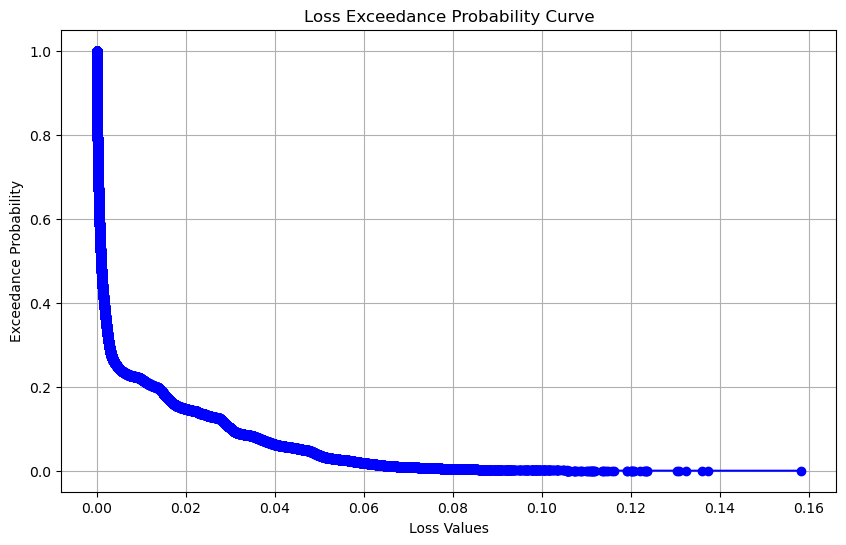

In [79]:
# Plot

plot_sorted_losses = sorted_losses / 40020283000000

plt.figure(figsize=(10, 6))
plt.plot(plot_sorted_losses, exceedance_probabilities, marker='o', linestyle='-', color='b')
plt.xlabel('Loss Values')
plt.ylabel('Exceedance Probability')
plt.title('Loss Exceedance Probability Curve')
plt.grid(True)
# plt.yscale('log')  # Optionally use a logarithmic scale for the y-axis
plt.show()

[      0.               0.               0.         ... 6038989.31612939
 6433144.75265861 6454268.62777974]
